In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ! pip install kaggle

In [3]:
import os

os.environ['KAGGLE_CONFID_DIR'] = '/content/drive/MyDrive/documents/kaggle'

In [4]:
! kaggle datasets download -d vivekmettu/wikitext2-data
! unzip -qq wikitext2-data.zip

Dataset URL: https://www.kaggle.com/datasets/vivekmettu/wikitext2-data
License(s): unknown
  0% 0.00/3.94M [00:00<?, ?B/s]
100% 3.94M/3.94M [00:00<00:00, 47.4MB/s]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nltk

In [6]:
train_file = open('/content/train.txt')

In [7]:
train_data = train_file.read()

In [8]:
valid_file = open('/content/test.txt')
valid_data = valid_file.read()

In [9]:
len(train_data)

10810591

In [10]:
len(valid_data)

1122901

In [11]:
import re

In [12]:
def clean_data(data):
    repl = ''

    data = re.sub('\(', repl, data)

    data = re.sub('\)', repl, data)

    for pattern in set(re.findall("<unk>", data)):
        data = re.sub(pattern, repl, data)

    for pattern in set(re.findall("=.*=", data)):
        data = re.sub(pattern, repl, data)

    for pattern in set(re.findall("[^\w ]", data)):
        repl = ''

        if pattern == '-':
            repl = ' '

        if pattern != '.' and pattern != "\'":
            data = re.sub("\\" + pattern, repl, data)

    return data

In [14]:
cleaned_data = clean_data(train_data)

In [15]:
cleaned_valid_data = clean_data(valid_data)

In [16]:
len(cleaned_data)

10099470

In [17]:
len(cleaned_valid_data)

1021137

In [76]:
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [77]:
sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 14})

In [78]:
tokenizer = get_tokenizer("basic_english", language="en")

In [79]:
path = '/content/train.txt'

In [80]:
with open(path, 'r') as file:
    lines = file.readlines()

    print(lines[1001])

In [81]:
len(lines)

37333

In [82]:
num_sentences = 25000

In [83]:
from nltk.tokenize import word_tokenize, sent_tokenize

In [84]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [85]:
sentences = sent_tokenize(cleaned_data)[:num_sentences]

In [86]:
valid_sentences = sent_tokenize(cleaned_valid_data)[:num_sentences]

In [87]:
words = set()

for sent in sentences:
    for word in str.split(sent, ' '):
        words.add(word)

words = list(words)
words.insert(0, "")

In [88]:
# words

In [89]:
SKIPGRAM_N_WORDS = 4
MIN_WORD_FREQUENCY = 5
MAX_SEQUENCE_LENGTH = 256

EMBED_DIM = 300
EMBED_MAX_NORM = 1
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [90]:
filtered_data = list(filter(lambda sent: len(sent) > 2 * SKIPGRAM_N_WORDS, map(tokenizer, sentences)))

In [91]:
filtered_valid_data = list(filter(lambda sent: len(sent) > 2 * SKIPGRAM_N_WORDS, map(tokenizer, valid_sentences)))

In [92]:
filtered_data[2]

['the',
 'season',
 'ran',
 'from',
 '1',
 'july',
 '2013',
 'to',
 '30',
 'june',
 '2014',
 '.']

In [93]:
total_train_tokens = sum(len(sent) for sent in filtered_data)
total_valid_tokens = sum(len(sent) for sent in filtered_valid_data)

print(f"Number of train sentences = {len(filtered_data)}, number of valid sentences = {len(filtered_valid_data)}")
print(f"Total tokens: train = {total_train_tokens}, valid = {total_valid_tokens}")
print(f"Average tokens in sentence = {total_train_tokens / len(filtered_data)}")

Number of train sentences = 23500, number of valid sentences = 7528
Total tokens: train = 566669, valid = 177979
Average tokens in sentence = 24.113574468085105


<ipython-input-94-7596e9dce5bb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot([len(sent) for sent in filtered_data])


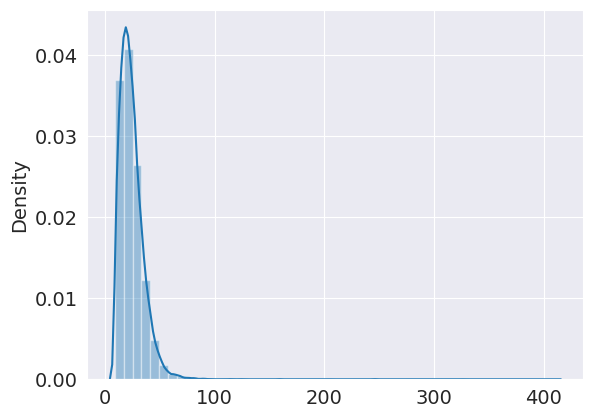

In [94]:
_ = sns.distplot([len(sent) for sent in filtered_data])

In [95]:
vocab = build_vocab_from_iterator(filtered_data, specials=["<unk>"], min_freq=MIN_WORD_FREQUENCY)

In [96]:
vocab.set_default_index(vocab["<unk>"])

In [97]:
VOCAB_SIZE = len(vocab)
print(f"Vocab size: {VOCAB_SIZE}")

Vocab size: 10091


In [98]:
filtered_data[1]

['their',
 '17th',
 'place',
 'finish',
 'in',
 '2012',
 '13',
 'meant',
 'it',
 'was',
 'their',
 'second',
 'consecutive',
 'season',
 'in',
 'league',
 'two',
 '.']

In [99]:
vocab(filtered_data[1])

[32, 1393, 204, 3190, 5, 442, 415, 963, 18, 8, 32, 97, 2949, 76, 5, 197, 43, 2]

In [100]:
vocab(["skibidi"])

[0]

In [101]:
def collate_fn(batch):
    '''
    batch is expected to be the list of paragraphs.

    context is represented as N=SKIPGRAM_N_WORDS past words
    and N future words.

    long paragraphs will be truncated to contain
    no more than MAX_SEQUENCE_LENGTH tokens.
    '''
    batch_input, batch_output = [], []

    for text in batch:
        text_token_ids = vocab(text)

        if MAX_SEQUENCE_LENGTH:
            text_token_ids = text_token_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_token_ids) - 2 * SKIPGRAM_N_WORDS):
            token_id_sequence = text_token_ids[idx: (idx + 2 * SKIPGRAM_N_WORDS + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            batch_input += [input_] * len(outputs)
            batch_output += outputs

    batch_input = torch.LongTensor(batch_input)
    batch_output = torch.LongTensor(batch_output)

    return batch_input, batch_output

In [102]:
train_loader = DataLoader(filtered_data, batch_size=BATCH_SIZE, pin_memory=True, collate_fn=collate_fn, shuffle=True)

In [103]:
valid_loader = DataLoader(filtered_valid_data, batch_size=BATCH_SIZE, pin_memory=True, collate_fn=collate_fn, shuffle=False)

In [104]:
next(iter(train_loader))

[tensor([3, 3, 3,  ..., 3, 3, 3]),
 tensor([  31,  289, 3446,  ..., 5046, 1153,    2])]

In [105]:
import torch.nn as nn
from torch.optim import Optimizer
from tqdm.notebook import tqdm

In [106]:
def train_epoch(model, train_loader, optimizer, loss_fn, device):
    train_loss = 0

    model.train()
    for X, y in tqdm(train_loader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    return train_loss / len(train_loader.dataset)

In [107]:
@torch.no_grad()
def evaluate_epoch(model, valid_loader, loss_fn, device):
    valid_loss = 0

    model.eval()
    for X, y in tqdm(valid_loader):
        X, y = X.to(device), y.to(device)

        output = model(X)
        loss = loss_fn(output, y)
        valid_loss += loss.item()

    return valid_loss / len(valid_loader.dataset)

In [108]:
from IPython.display import clear_output

In [109]:
def plot_stats(train_loss_history, valid_loss_history, title):
    clear_output()

    plt.figure(figsize=(14, 6))

    plt.plot(train_loss_history, label='train loss')
    plt.plot(valid_loss_history, label='valid loss')
    plt.title(title + ' loss')

    plt.legend()
    plt.show()

In [110]:
def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title, scheduler=None):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate_epoch(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        plot_stats(train_loss_history, valid_loss_history, title)

        if scheduler is not None:
            scheduler.step()

In [111]:
class Word2VecModel(nn.Module):
    def __init__(self, embed_dim, embed_max_norm, vocab_size):
        super().__init__()

        self.embeds = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            max_norm=embed_max_norm
        )

        self.decoder = nn.Linear(embed_dim, vocab_size)

    def forward(self, X):
        return self.decoder(self.embeds(X))

In [112]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [113]:
loss_fn = nn.CrossEntropyLoss()

In [114]:
model = Word2VecModel(EMBED_DIM, EMBED_MAX_NORM, VOCAB_SIZE).to(device)

In [115]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [116]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)

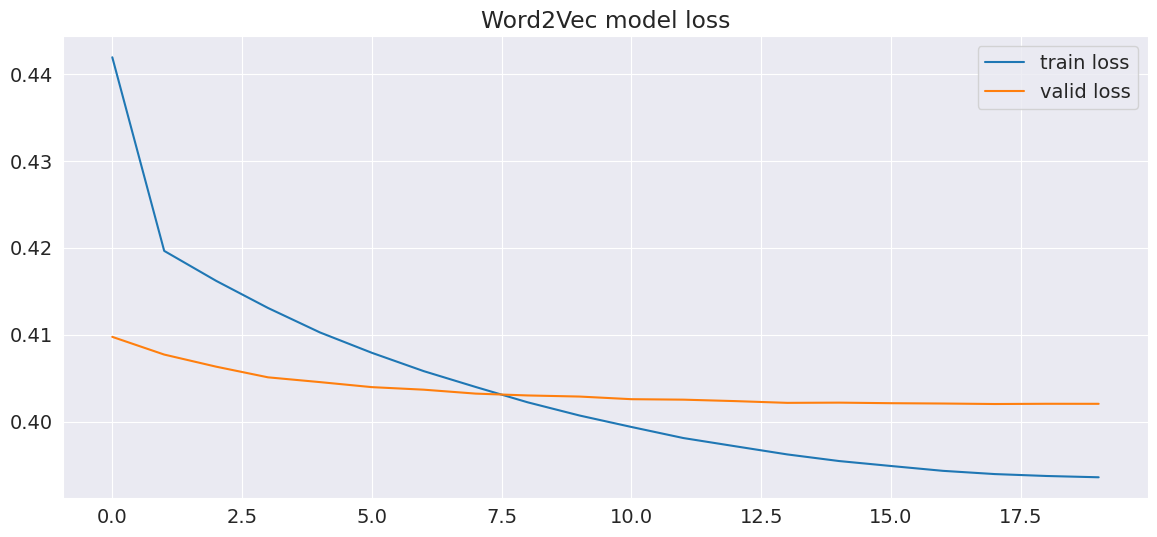

In [117]:
fit(model, train_loader, valid_loader, optimizer, loss_fn, device, NUM_EPOCHS, 'Word2Vec model', scheduler)

In [118]:
embed_matrix = model.embeds.weight.detach().cpu()
embed_norms = (embed_matrix ** 2).sum(1).sqrt()

In [119]:
embed_norms

tensor([0.9998, 0.9998, 1.0000,  ..., 1.0014, 1.0005, 1.0000])

In [120]:
def get_similarities(embed_vector):
    similarities = embed_matrix @ embed_vector / embed_norms / torch.norm(embed_vector)
    top_indices = similarities.argsort(descending=True)
    return similarities, top_indices

In [121]:
def get_similar(query, num_similar=5):
    print(f"Processing query = {query}")
    split_query = re.split('([^a-zA-Z0-9])', query)
    index = vocab[split_query[0]]
    embed_vector = torch.clone(embed_matrix[index])
    if index > 0:
        print(f"Found word: {split_query[0]} in vocab")
    else:
        print(f"Word {split_query[0]} not found in vocab, using <unk>")

    for i in range(2, len(split_query), 2):
        index = vocab[split_query[i]]
        if index > 0:
            print(f"Found word: {split_query[i]} in vocab", end='')
        else:
            print(f"Word {split_query[i]} not found in vocab, using <unk>", end='')

        print(f"Operation {split_query[i-1]}")

        if split_query[i-1] == '+':
            embed_vector += embed_matrix[index]
        elif split_query[i-1] == '-':
            embed_vector -= embed_matrix[index]
        else:
            raise ValueError("unknown operation")

    similarities, top_indices = get_similarities(embed_vector)
    itos = vocab.get_itos()
    print("Top similar: ")
    for top_index in top_indices[:num_similar]:
        print(f"{itos[top_index]}: sim = {similarities[top_index]}")

In [123]:
get_similar('man', num_similar=10)

Processing query = man
Found word: man in vocab
Top similar: 
man: sim = 0.9999998807907104
woman: sim = 0.64169842004776
smoking: sim = 0.5802552103996277
young: sim = 0.5669386386871338
lover: sim = 0.5610896348953247
immortal: sim = 0.5349895358085632
dreams: sim = 0.5275849103927612
girl: sim = 0.5056712627410889
knows: sim = 0.4939877390861511
haddock: sim = 0.4818078279495239


In [124]:
get_similar('king', num_similar=10)

Processing query = king
Found word: king in vocab
Top similar: 
king: sim = 1.0
diarmait: sim = 0.7350959181785583
toirdelbach: sim = 0.7106389403343201
mac: sim = 0.7087079882621765
dublin: sim = 0.6988779902458191
kamehameha: sim = 0.6900980472564697
anselm: sim = 0.6837323904037476
grandfather: sim = 0.6818142533302307
son: sim = 0.6675704121589661
murchad: sim = 0.6657541990280151


In [125]:
get_similar('bread', num_similar=10)

Processing query = bread
Found word: bread in vocab
Top similar: 
bread: sim = 0.9999998807907104
cheese: sim = 0.8855605125427246
tea: sim = 0.7870277166366577
beer: sim = 0.7710273265838623
dole: sim = 0.7679107189178467
lands: sim = 0.7061058878898621
widows: sim = 0.6798252463340759
easter: sim = 0.6629225611686707
biddenden: sim = 0.6606702208518982
cakes: sim = 0.6450850367546082


In [132]:
get_similar('bread+cheese', num_similar=10)

Processing query = bread+cheese
Found word: bread in vocab
Found word: cheese in vocabOperation +
Top similar: 
cheese: sim = 0.9709805846214294
bread: sim = 0.9709568023681641
beer: sim = 0.8283534049987793
tea: sim = 0.8275481462478638
dole: sim = 0.7829916477203369
lands: sim = 0.7551373243331909
widows: sim = 0.7050003409385681
easter: sim = 0.7003005146980286
biddenden: sim = 0.6894670128822327
cakes: sim = 0.6605691909790039
